# Margin density drift detection on wine quality dataset

### Overview

The margin density drift detector (MD3) ([Sethi and  Kantardzic, 2015](https://www.sciencedirect.com/science/article/pii/S1877050915017871)) quantifies the percentage of predictions made by a probabilistic binary classifier at the decision boundary (as defined by a margin).  This quantity is known as the margin density.  The margin density is compared to an allowable margin density range.  Drift is detected if the calculated margin density for a given batch falls outside of the specified margin density range.  Care should be taken when setting the margin density range.  This can be informed, for example, by calculating the margin density mean and variance on out-of-fold instances when performing k-fold cross-validation, or on data batches from an additional holdout set that are characteristically similar to the data on which the binary classifier was trained.  Low and high margin densities relative to the allowable density range can be indicative of virtual drift, concept drift and/or general changes in model performance.

Many alternative drift detection methods focus on tracking changes in the distribution of data inputs.  These approaches can be prone to generating false positives as they implicitly give equal importance to all features, even those that are of very little importance to the classifier.  The utility of the MD3 approach is that it uses the change in the percentage of samples contained within a classifier's decision boundary (i.e., margin) as a proxy for measuring changes in the probability distribution of the labels given the data inputs, _without actually requiring any labeled data_.  This approach tends to be more robust against false positives as the classifier accounts for differences in feature importances, giving little emphasis to features that do not affect classification performance.

### Dataset

The instances contain wine characteristics such as citric acid, pH, residual sugar and density, while the target value represents the quality of the wine (rated on a 0-10 scale).  We combine two feature-identical datasets: one for red wine (1599 instances) and one for white wine (4898 instances).  The combined dataset consists entirely of numerical features and can each be obtained from the [tensorflow-datasets](https://www.tensorflow.org/datasets/catalog/wine_quality) library, which can be installed with pip: 

```bash
pip install tensorflow-datasets
```  

For demonstration purposes and in order to show the utility of this detection method, we will convert this multi-class dataset into a binary classification dataset by reconstructing the target variable into 'low quality' (target = 0) and 'high quality' (target = 1) categories, assigning quality values of 6 or more to the 'high quality' category.  


In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import tensorflow as tf
import tensorflow_datasets as tfds

from alibi_detect.cd import MarginDensityDrift

logging.getLogger("tensorflow").setLevel(logging.WARNING)
np.random.seed(0)
tf.random.set_seed(0)
%matplotlib inline

### Load wine quality datasets

The ```fetch_wine_quality``` function returns a our data instances, targets, and feature names.  Within that function we call the ```load``` method of ```tensorflow_datasets``` which returns a tf.data.Dataset object that we convert into numpy arrays.  The numpy arrays are randomly shuffled before being returned.

In [2]:
wines = ['white','red']

In [3]:
def fetch_wine_quality(wines):
    
    X, y = [], []
    
    for wine in wines:
        ds = tfds.load("wine_quality/"+wine, split=tfds.Split.TRAIN, batch_size=-1)
        numpy_ds = tfds.as_numpy(ds)
        data = np.array(list(numpy_ds['features'].values())).T
        target = np.array(list(numpy_ds['quality']))
        feature_names = list(numpy_ds['features'].keys())
        X.append(data)
        y.append(target)
    
    X = np.array([j for i in X for j in i])
    y = np.array([j for i in y for j in i])
    y = np.where(y>=6,1,0) # convert target to binary
    X, y = shuffle(X, y) # shuffle rows
        
    return X, y, feature_names

In [4]:
X, y, feature_names = fetch_wine_quality(wines)

We split the data into train, validation, and test sets.  The train data will be used to train our binary classifier model.  The validation data may be used to calculate baseline margin density statistics (alternatively, if performing k-fold cross-validation the train data could be used and baseline statistics could be calculated on out-of-fold instances).  The test data will be used to evaluate margin density drift.

In [5]:
n_samples_train = 4000
n_samples_val = 2000

X_train, y_train = X[:n_samples_train],  y[:n_samples_train]
X_val, y_val = X[n_samples_train:(n_samples_train+n_samples_val)], y[n_samples_train:(n_samples_train+n_samples_val)] 
X_test, y_test = X[(n_samples_train+n_samples_val):], y[(n_samples_train+n_samples_val):]

X_train.shape, X_val.shape, X_test.shape

((4000, 11), (2000, 11), (497, 11))

### Rescale data

We apply min-max scaling to the data inputs.

In [6]:
sc = MinMaxScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)
X_val_scaled = sc.transform(X_val)
X_test_scaled = sc.transform(X_test)

### Train classifier model

We define and train a tensorflow classifier model on our scaled data.  Once the model is trained we can have a look at its performance across each of the datasets.

In [7]:
input_dim = X_train_scaled.shape[1]

# define and train model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(input_dim,)),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, batch_size=16, epochs=1000, verbose=False)

print('Train accuracy: {0:.4f}'.format(model.evaluate(X_train_scaled, y_train)[1]))
print('Validation accuracy: {0:.4f}'.format(model.evaluate(X_val_scaled, y_val)[1]))
print('Test accuracy: {0:.4f}'.format(model.evaluate(X_test_scaled, y_test)[1]))

125/125 [==============================] - 0s 694us/step - loss: 0.4596 - accuracy: 0.7740
Train accuracy: 0.7740
63/63 [==============================] - 0s 1ms/step - loss: 0.5053 - accuracy: 0.7500
Validation accuracy: 0.7500
16/16 [==============================] - 0s 1ms/step - loss: 0.5005 - accuracy: 0.7646
Test accuracy: 0.7646


We see similar performance across each of the datasets.

### Calculate baseline margin density statistics

We calculate the margin density mean and standard deviation across a set of non-overlapping data chunks taken from the validation dataset.  We start by defining `margin` to be `0.1` and then initiating our drift detector with our trained classifier model. 

In [8]:
margin = 0.1

In [9]:
cd = MarginDensityDrift(model=model, margin=margin)

By calling the `score` method of our drift detector, we can pass data in and get back the margin density score, which is just simply the number of predictions made within the decision boundary (i.e., margin) divided by the total number of predictions made.  If we do this across each chunk of data we can calculate a baseline margin density mean and standard deviation.

In [10]:
densities = []

for chunk in np.array_split(X_val_scaled,10):
    margin_density = cd.score(X=chunk)
    densities.append(margin_density)

md_mean = np.mean(densities)
md_std = np.std(densities)

md_mean, md_std

(0.0885, 0.0255)

Using the baseline mean and standard deviation from the validation data, we can set the upper and lower bounds of `density_range`. 

In [11]:
n_std = 1
density_range = (md_mean-n_std*md_std, md_mean+n_std*md_std)
density_range

(0.063, 0.11399999999999999)

### Detect drift

Now that we have calculated `density_range,` we can initialize a new drift detector using that input.  This detector is now ready to detect drift on unseen data.

In [12]:
cd = MarginDensityDrift(model=model, margin=margin, density_range=density_range)

We can test for drift in our test set.  We do not expect there to be drift in our test set as it was characteristically similar to the train and validation sets (randomly shuffled before splitting) and achieved similar performance (as shown above).  

In [13]:
# check if drift in batch
labels = ['No!', 'Yes!']
preds = cd.predict(X_test_scaled)
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


When we have a closer look, we see that the calculated margin density of the test set lies well within the density range we specified.  This is what we expect.

In [14]:
print(preds['data']['margin_density'])
print(preds['data']['density_range'])

0.08651911468812877
(0.063, 0.11399999999999999)


We can artificially introduce drift into our features inputs, but first let's have a look at the permutation feature importance of our trained classifier model to understand the relative importances of each feature.  Permutation feature importance can be computed using the [eli5](https://github.com/eli5-org/eli5) library, which can be installed with pip: 

```bash
pip install eli5
```

In [15]:
from eli5.permutation_importance import get_score_importances

def score(X, y):
    y_pred = np.round(model.predict(X))
    return accuracy_score(y, y_pred)

base_score, score_decreases = get_score_importances(score, X_train_scaled, y_train)
feature_importances = np.mean(score_decreases, axis=0)

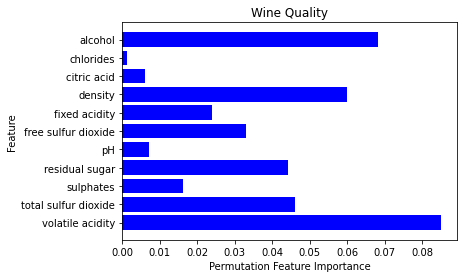

In [16]:
plt.barh(feature_names, feature_importances, color='blue')
plt.title('Wine Quality')
plt.ylabel('Feature')
plt.xlabel('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

Based on permutation feature importance, the most important features appear to be `alcohol` and `volatile acidity`, whereas least the important features appear to be `chlorides`, `citric acid` and `pH`.  Using this information we can introduce feature drift into our test set and measure the response of our drift detector to see if it is more responsive to important features.

We can start by introducing a covariate shift and a small amount of Gaussian noise to the `alcohol` and `volatile acidity` features.

In [17]:
def random_normal_shift(X, mu, sigma, feature):
    
    np.random.seed(0)
    X_shifted = X.copy()
    idx = list(feature_names).index(feature)
    random_shift = np.random.normal(mu, sigma, X_shifted.shape[0])
    X_shifted[:,idx] = X_shifted[:,idx] + random_shift
    
    return X_shifted

In [18]:
mu = 0.5
sigma = 0.015

In [19]:
features = ['alcohol', 'volatile acidity']  # most important features
for feature in features:
    X_shifted = random_normal_shift(X=X_test_scaled, mu=mu, sigma=sigma, feature=feature)
    preds = cd.predict(X_shifted)
    print('Shifted Feature: ',feature)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Margin Density: {}'.format(preds['data']['margin_density']))
    print('Density Range: {}'.format(preds['data']['density_range']))
    print('\n')

Shifted Feature:  alcohol
Drift? Yes!
Margin Density: 0.012072434607645875
Density Range: (0.063, 0.11399999999999999)


Shifted Feature:  volatile acidity
Drift? Yes!
Margin Density: 0.04627766599597585
Density Range: (0.063, 0.11399999999999999)




The drift is detected when applied to these important features.  We can can now introduce the same shift to the `chlorides`, `citric acid` and `pH` features and check the response of our detector.

In [20]:
features = ['chlorides', 'citric acid', 'pH']  # least important features
for feature in features:
    X_shifted = random_normal_shift(X=X_test_scaled, mu=mu, sigma=sigma, feature=feature)
    preds = cd.predict(X_shifted)
    print('Shifted Feature: ',feature)
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Margin Density: {}'.format(preds['data']['margin_density']))
    print('Density Range: {}'.format(preds['data']['density_range']))
    print('\n')

Shifted Feature:  chlorides
Drift? No!
Margin Density: 0.06841046277665996
Density Range: (0.063, 0.11399999999999999)


Shifted Feature:  citric acid
Drift? No!
Margin Density: 0.06841046277665996
Density Range: (0.063, 0.11399999999999999)


Shifted Feature:  pH
Drift? No!
Margin Density: 0.07847082494969819
Density Range: (0.063, 0.11399999999999999)




No drift is detected among shifted features of low feature importance to our model.

Because the MarginDensityDrift detector relies on a trained binary classifier model, this detection method is favorable in situations where one needs to detect drift only when classification performance is impacted.  Therefore, in certain cases this detection method may be more robust to false positives.